# Continuous Wave

In [1]:
from __future__ import division
import tqdm
import os
import sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
# sys.path.append('/workspace/projects/TES/scripts')
import numpy as np
import matplotlib
# matplotlib.use('nbAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from lmfit import Model, Parameters
import pymc
import seaborn
from scipy.stats import norm
from scipy.signal import savgol_filter
from scipy.fftpack import fft, rfft, fftshift
import pickle
import time as datetime
import pandas
import pprint

import heralded_pulses_analysis as hpa
import pulse_averaging_cw as pacw
import pulse_fit_v05 as pf
import pulse_fit_v06 as pf6
import single_photon_model_no_shift as noshift
import pulse_averaging as pa
import thres_poiss
import pulse_discrimination as pd
import thres
import stats_proc as sp

# Single Photon Model

### Step 1a) Calculate Height Thresholds or...

In [4]:
# Imports CW traces
directories = ['/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more_more/']
results_directory = './'
filelist=[]
for directory_name in directories:
    subfilelist = np.array(glob.glob(directory_name + '*.trc'))
    filelist.extend(subfilelist)
filelist = np.array(filelist)
# filelist = np.flipud(np.sort(filelist))
filelist = np.sort(filelist)
print(filelist[0:2])
print len(filelist)

[ '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00000.trc'
 '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00001.trc']
400000


In [5]:
# Set left and right time limits of each trace to process
t_initial = None
t_final = None
height_th = 0.072 #to be updated with pt of minimal overlap between n=0 and n=1 distributions
t0 = 0.5e-6

<IPython.core.display.Javascript object>


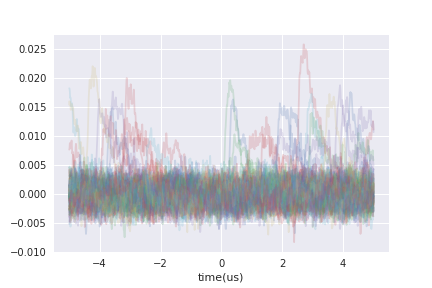

In [6]:
# Performs an initial plot
%matplotlib notebook
reload(hpa)
hpa.pplot(filelist[:1000], height_th, t_initial, t_final)
# plt.ylim(0,0.02)
# plt.plot(time_f*1e6+0.3,2*signal_f)

In [63]:
# Extract SOME trace properties, just to generate height threshold (first pass)
reload(hpa)
data = np.array([hpa.param_extr(f,t_initial,t_final,height_th,t0)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [03:54<00:00, 35.51it/s]


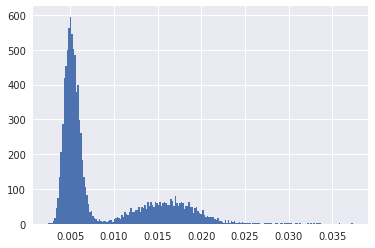

In [64]:
heights = data['height']
pnr_height = np.histogram(heights, 200)
# np.savetxt(results_directory+'heights_cw_derived_single_diode_pulse.dat', heights)
%matplotlib inline
plt.figure()
plt.hist(heights,200);

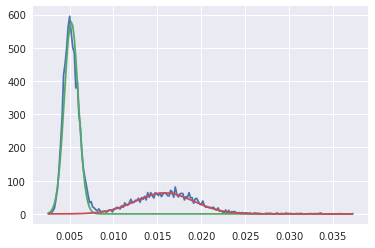

In [78]:
reload(thres_poiss)
thres_poiss.gauss_fit_interp(pnr_height, min_peak_sep=0.01, weighted=True,plot=True)

In [79]:
# Detect valleys separating peaks or...
th = thres_poiss.thresholds_N(pnr_height, min_peak_sep=0.01, weighted=True)
np.savetxt(results_directory+'height_thresholds_cw_derived_single_diode_pulse.dat',th)
print th

[(0.0075903632447402967, 0.006456132310872718, 0.0013507919612660846)]


### Step 1b) or.. load threshold file if exists

In [80]:
th = np.loadtxt(results_directory+'height_thresholds_cw_derived_single_diode_pulse.dat')
print th

[ 0.00759036  0.00645613  0.00135079]


[ 0.0041726  0.0048918  0.0051026 ...,  0.005518   0.012338   0.0042904]


<IPython.core.display.Javascript object>


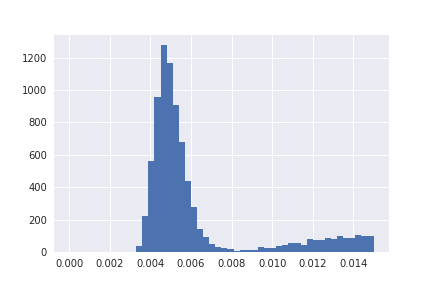

In [83]:
heights = np.loadtxt(results_directory+'heights_cw_derived_single_diode_pulse.dat')
print heights
%matplotlib notebook
plt.figure()
plt.hist(heights,50,range=(0,0.015));

In [84]:
# Noise Amplitude Standard Deviation
(mu0,sigma0) = norm.fit(heights[(heights<th[0])])
print mu0, sigma0, sigma0/mu0

0.00497876525838 0.000706929139941 0.141988847285


In [158]:
# Single Photon Amplitude Standard Deviation
# (mu,sigma) = norm.fit(heights[(heights>th[0][0])&(heights<th[1][0])])
# print mu, sigma, sigma/mu

In [85]:
# Update height threshold, ,reprocess trace parameters
height_th = th[0]
print height_th

0.00759036324474


### Second pass to get better height threshold estimation (not necessary under mode(signal))

In [7]:
# Using the height_th obtained earlier as input to the SET-RESET switch, 
# Process the traces again and extract the max heights on the 'clamped' traces (without partial edge pulses)
reload(pd)
reload(hpa)
data_second_pass = np.array([hpa.param_extr(f,t_initial,t_final,height_th,t0)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [03:29<00:00, 42.31it/s]


(0.006, 0.015)

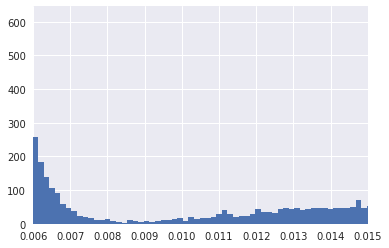

In [17]:
heights_second_pass = data_second_pass['height_clamped']
pnr_height_second_pass = np.histogram(heights_second_pass, 200)
np.savetxt(results_directory+'heights_second_pass_cw_derived_single_diode_pulse.dat', heights_second_pass)
%matplotlib inline
plt.figure()
plt.hist(heights_second_pass,200);
plt.xlim(0.006,0.015)

In [9]:
th = thres_poiss.thresholds_N(pnr_height_second_pass, min_peak_sep=0.01, weighted=True)
np.savetxt(results_directory+'height_thresholds_second_pass_cw_derived_single_diode_pulse.dat',th)
print th

[(0.0096050963109244689, 0.0015831915905149061, 1.381240583020471e-07)]


In [7]:
th = np.loadtxt(results_directory+'height_thresholds_second_pass_cw_derived_single_diode_pulse.dat')
print th

[  9.60509631e-03   1.58319159e-03   1.38124058e-07]


In [8]:
height_th = th[0] #refresh height_th with the threshold obtained from the second pass.
print height_th

0.00960509631092


### Step 2a) Calculate Single Photon Model or...
via filtering for n=1 events using height_th obtained earlier

In [44]:
reload(hpa)
data_height_from_cw = np.array([hpa.param_extr(f,t_initial,t_final,height_th,t0)
                 for f
                 in tqdm.tqdm(filelist[:])])

100%|██████████| 10000/10000 [03:44<00:00, 33.57it/s]


In [45]:
areas_height_from_cw = data_height_from_cw['area_win']

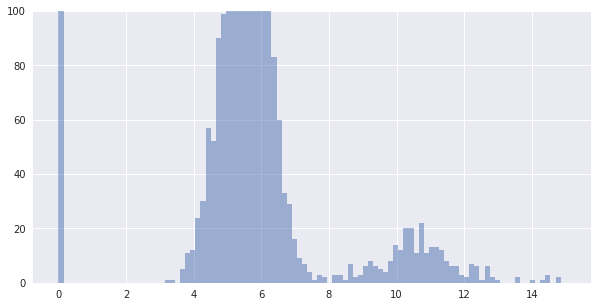

In [46]:
%matplotlib inline
plt.figure(figsize=(10,5))
# plt.hist(areas_height_from_pulsed,100,
#          range=(0,3),
#          alpha=0.5,
#          label='height from pulsed'
#         );
plt.hist(areas_height_from_cw,100,
         range=(0,15),
         alpha=0.5,
         label='areas: height from cw'
        );
# plt.legend()
plt.ylim(0,100)
# plt.xlim(0,1.5*10)
# plt.savefig(results_directory+'area_histo.pdf')
plt.show()

In [47]:
print ('n=0: {}'.format(np.sum(areas_height_from_cw<2)))
print ('n=1: {}'.format(np.sum((areas_height_from_cw>2)&(areas_height_from_cw<8))))
print ('n=2: {}'.format(np.sum((areas_height_from_cw>8)&(areas_height_from_cw<14))))
print ('n>2: {}'.format(np.sum(areas_height_from_cw>14)))

n=0: 7683
n=1: 2043
n=2: 255
n>2: 19


In [99]:
nbar = -np.log(.7688)
print nbar
import math
poiss = lambda nbar,k: nbar**k*np.exp(-nbar)/math.factorial(k)
print np.array([poiss(0.2458,i) for i in [0,1,2]])*400000

0.262924421326
[ 312831.45000398   76893.97041098    9450.26896351]


In [49]:
2035/poiss(0.2,1)

12427.773064279727

In [14]:
areas_height_from_cw = np.loadtxt(results_directory+'areas_height_from_cw.dat')

In [15]:
pnr_height_from_cw = np.histogram(areas_height_from_cw, 200)
# pnr_height_from_cw = [pnr_height_from_cw[0][1:], pnr_height_from_cw[1][1:]]

In [16]:
# Use multi-gaussian fitting algorithm to find centers and sigmas
# Does not assume population is Poisson distributed.
reload(thres)
pnr_height_from_cw = np.histogram(areas_height_from_cw, 200)
result = thres.gauss_fit_poiss_ph(pnr_height_from_cw,
                                          min_peak_sep=3, 
                                          threshold=None, 
                                          weighted=True)

[  5.5040716   10.54947057] [7280  567]


400000
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Variables]]
    n_bar:          0.24582361 (init= 0.2)
    A:              62307.0471 (init= 21840)
    Delta_E:        38.2683719 (init= 5.045399)
    sigma_p:        0.66921281 (init= 0.6752372)
    g1_center:      5.47193893 (init= 5.504072)
    g2_center:      10.5221354 (init= 10.54947)
    g1_amplitude:   11978.4583  == 'A * exp(-n_bar) * n_bar**1 / factorial(1)'
    g2_amplitude:   1472.29395  == 'A * exp(-n_bar) * n_bar**2 / factorial(2)'
    g1_sigma:       0.66921281  == 'sigma_p * sqrt(1)'
    g2_sigma:       0.94640983  == 'sigma_p * sqrt(2)'

7.12538717513


<IPython.core.display.Javascript object>


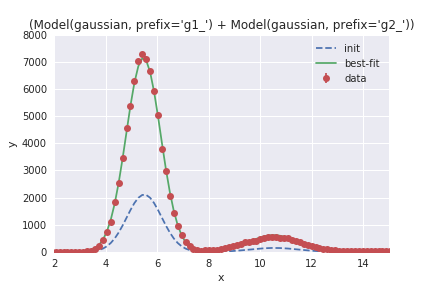

(0, 8000)

In [17]:
print np.sum(pnr_height_from_cw[0])
print result.fit_report()
print result.redchi
plt.figure()
result.plot_fit()
plt.xlim(2,15)
plt.ylim(0,8000)

In [74]:
len(result.components)

2

In [108]:
reload(thres)
area_mus, area_sigmas = thres.gauss_fit_results(pnr_height_from_cw,
                                          min_peak_sep=3, 
                                          threshold=None, 
                                          weighted=True)
print area_mus, area_sigmas

[  5.5040716   10.54947057] [7280  567]
[  5.47193893  10.52213549] [ 0.66921281  0.94640983]


In [109]:
th_areas = [(area_mus[i]-2*area_sigmas[i],area_mus[i]+2*area_sigmas[i]) for i,_ in enumerate(area_mus)]
np.savetxt(results_directory+'area_thresholds_single_diode_pulse_from_cw.dat', th_areas)
print th_areas

[(4.1335133067984859, 6.8103645538534181), (8.6293158240497938, 12.414955162090209)]


In [9]:
th_areas = np.loadtxt(results_directory+'area_thresholds_single_diode_pulse_from_cw.dat')
print th_areas

[[  4.13351331   6.81036455]
 [  8.62931582  12.41495516]]


In [178]:
# print 'single photon amplitude: truncated distribution for prior' 
# print 'left limit = {}'.format((area_mus[1]-4*area_sigmas[1])/2/area_mus[0])
# print 'center = {}'.format((area_mus[1])/2/area_mus[0])
# print 'sigma = {}'.format((area_sigmas[1])/area_mus[0])
# print 'right limit = {}'.format((area_mus[1]+4*area_sigmas[1])/2/area_mus[0])

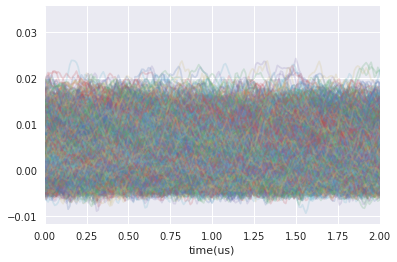

In [111]:
mask_1ph = (areas_height_from_cw>th_areas[0][0])&(areas_height_from_cw<th_areas[0][1])
np.savetxt(results_directory+'mask_1ph_cont_from_cw.dat', mask_1ph)
# reload(hpa)
hpa.pplot(filelist[mask_1ph], height_th)
plt.xlim(0,2);

In [10]:
mask_1ph = np.loadtxt(results_directory+'mask_1ph_cont_from_cw.dat').astype('bool')
print mask_1ph

[False False False ..., False False False]


[  1.99999994e-09   1.99999994e-09   1.99999994e-09 ...,   1.99999994e-09
   1.99999994e-09   1.99999994e-09]


<IPython.core.display.Javascript object>


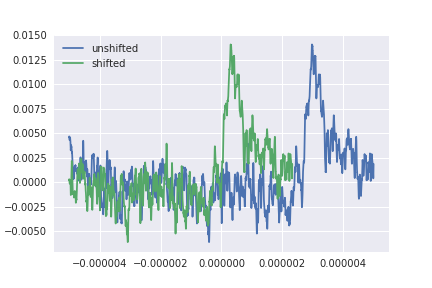

ModeResult(mode=array([-0.00031221]), count=array([3]))


<IPython.core.display.Javascript object>


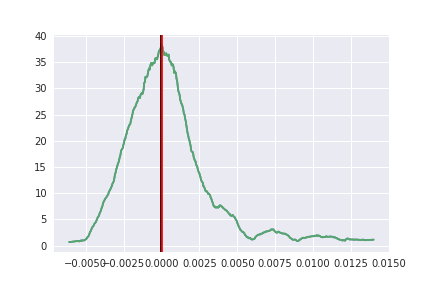

binsize = 4.0300000459e-05
-1.55007503927e-05
binsize = 4.0300000459e-05


In [62]:
# testing of shifting- to be del after development
reload(hpa)
reload(pacw)
%matplotlib notebook
t,s = hpa.trace_extr(filelist[mask_1ph][33],height_th)
print np.diff(t)
plt.figure()
plt.plot(t,s,label='unshifted')
plt.plot(t,pacw.time_offset(t,s,height_th),label='shifted')
plt.legend()
plt.show()
from scipy import stats
print stats.mode(savgol_filter(s,101,1))
plt.figure()
# plt.hist(s,200);
print hpa.find_bg(s)
plt.axvline(hpa.find_bg(s),color='black')
plt.axvline(np.median(s[s<height_th]),color='red')

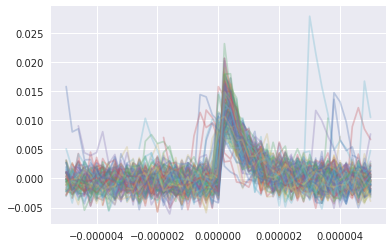

In [370]:
reload(pacw)
flags = []
plt.figure()
for i in np.arange(200):
    t,s = hpa.trace_extr(filelist[mask_1ph][i],height_th)
    ss = pacw.time_offset(t[:],s[:],height_th)
    plt.plot(t[::100],ss[::100],alpha=0.3)
    try:
        if np.max(ss[(t>0)&(t<1e-6)])<height_th:
            flags.append(True)
        else:
            flags.append(False)
    except:
        flags.append(True)

In [371]:
print np.sum(flags)/200*100
print height_th

2.0
0.00960509631092


In [340]:
flags=np.array(flags)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 75012 but corresponding boolean dimension is 200
  


(-4e-06, 4e-06)

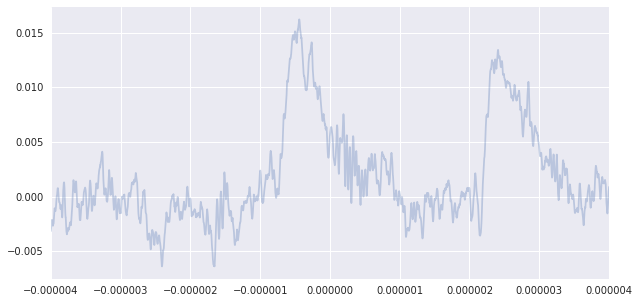

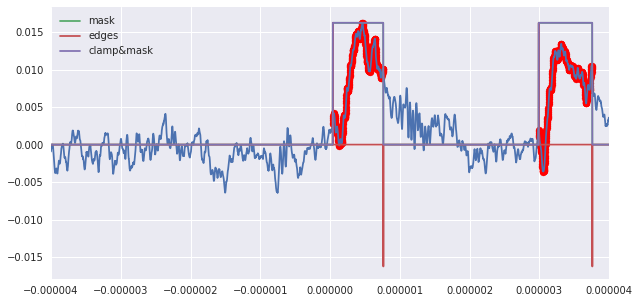

In [358]:
reload(pacw)
t,s = hpa.trace_extr(filelist[mask_1ph][flags][4],height_th)
plt.figure(figsize=(10,5))
plt.plot(t[::],pacw.time_offset(t[:],s[:],height_th)[::],alpha=0.3)
plt.xlim(-4e-6,4e-6)
[mask, clamp, edges, left_edges, right_edges] = pd.discriminator(
    t, 
    s,
    dt_left=100e-9,
    dt_right=0,
    height_th=height_th,
    method=2,
Plot=True) 
plt.xlim(-4e-6,4e-6)

In [372]:
# Generate average pulse with horizontal offset correction
reload(pacw)
time_p, signal_p = pacw.trace_ave(filelist[:10000][mask_1ph[:10000]], height_th, t_initial, t_final)

# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_p, signal_p)

fit_model = Model(one_pulse)

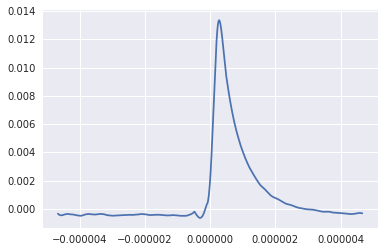

In [374]:
plt.figure()
plt.plot(time_p,signal_p)

In [377]:
# Use model to generate another model that has horizontal offset correction
reload(pacw)
time_f, signal_f, sigma_f = pacw.fit_corrected_pulse(filelist[:10000][mask_1ph[:10000]],
                                                    height_th,
                                                   fit_model,
                                                   t_initial,
                                                   t_final)

<Container object of 3 artists>

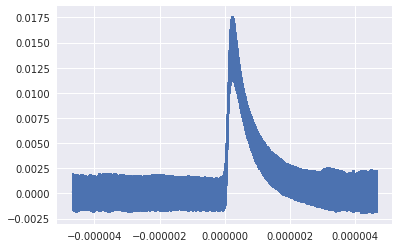

In [378]:
plt.figure()
plt.errorbar(time_f, signal_f, sigma_f)

[]

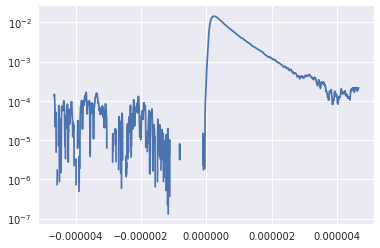

In [379]:
# plots single photon model in semilog axis to check vertical offset correction 
%matplotlib inline
plt.figure()
plt.plot(time_f,signal_f)
plt.semilogy()

In [380]:
np.save(results_directory + 'ph1_model_from_cw_disc.npy',
            np.array(zip(time_f, signal_f, sigma_f)))

### Step 2b) or... Load Single Photon Model

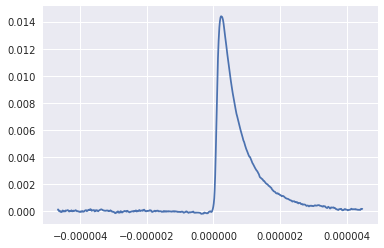

In [381]:
# Loads Single Photon Model
%matplotlib inline
ph1_model = np.load(results_directory + 'ph1_model_from_cw_disc.npy')
plt.figure()
time_f, signal_f = ph1_model[:,0], ph1_model[:,1]
time_f, signal_f = time_f[:-100], signal_f[:-100]
plt.plot(time_f,signal_f)
# plt.xlim(-200e-9,600e-9)

In [144]:
def rise_time(time,signal,plot=True):
    """returns 10% to 90% rise timing"""
    amplitude = np.max(signal)
    idxpeak = np.argmax(signal)
    def find_idx(array,value):
        array=np.array(array)
        return np.argmin(np.abs(array-value))
    t10 = time[find_idx(signal[:idxpeak],0.1*amplitude)]
    t90 = time[find_idx(signal[:idxpeak],0.9*amplitude)]
    risetime = t90-t10
    if plot:
        plt.figure()
        plt.plot(time,signal)
        plt.axvline(t10,linestyle='--')
        plt.axvline(t90,linestyle='--')
    return risetime

129.999996323


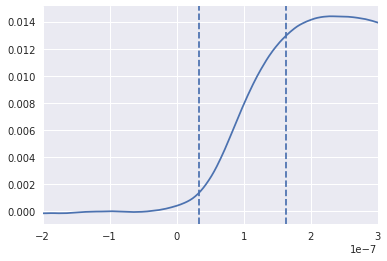

In [382]:
print rise_time(time_f,signal_f)*1e9
# print rise_time(time_p,signal_p)*1e9
plt.xlim(-200e-9,300e-9);

width at height_th = 0.58199998354us


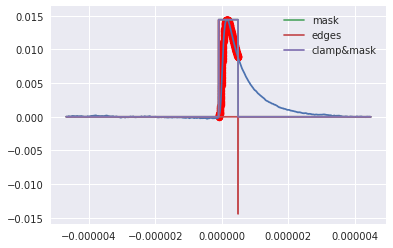

In [11]:
# "Width" of average single photon pulse: 
# Use this to determine the average trace length = 10 us - width
[mask, clamp, edges, left_edges, right_edges] = pd.discriminator(time_f, signal_f, 
                                                                 dt_left=0*300e-9,
                                                                 dt_right=0*1400e-9, 
                                                                 height_th=height_th, 
                                                                 Plot=True, 
                                                                 method=2)
print('width at height_th = {}us'
    .format(1e6*(time_f[right_edges[0]]-time_f[left_edges[0]])))

# Fit to 2 photon traces

### Step 3: Import all CW traces
if you haven't already, and perform filtering on them...

In [18]:
# Imports double diode excitation traces
filelist_cont=filelist
# filelist_cont = np.flipud(np.sort(filelist_cont))
print(filelist_cont[:2])
len(filelist_cont)

[ '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00000.trc'
 '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00001.trc']


400000

In [26]:
data_cont = data_height_from_cw
# reload(hpa)
# from multiprocess import Pool
# def param_extr_poolable(f):
#     return hpa.param_extr(f, t_initial, t_final, h_th=height_th)
# tasks = tqdm.tqdm(filelist_cont[:])
    
# data_cont = Pool(4).map(param_extr_poolable,tasks)
# data_cont = np.array([hpa.param_extr(f, t_initial, t_final, h_th=height_th)
#                  for f
#                  in tqdm.tqdm(filelist_cont[:])])
# data_cont=data

100%|██████████| 400000/400000 [41:47<00:00, 215.09it/s] 


KeyboardInterrupt: 

KeyboardInterrupt: 

KeyboardInterrupt: 

In [34]:
data_cont = np.loadtxt(results_directory+'data_cont.dat')

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  5.33595556,  0.        ])

In [43]:
# Generate Area histograms
data_cont = np.array(data_cont)
areas_height_from_cw = data_cont['area_win']
np.savetxt(results_directory+'areas_height_from_cw.dat',areas_height_from_cw)
np.savetxt(results_directory+'data_cont.dat',data_cont)

In [76]:
# Or Load...
areas_height_from_cw = np.loadtxt(results_directory+'areas_height_from_cw.dat')

In [37]:
# use the area to count the number of photons
pnr_height_from_cw = np.histogram(areas_height_from_cw, 200)
# remove the first bin that is not gaussian, and will affect the threshold detection algorithm
pnr_height_from_cw = [pnr_height_from_cw[0][1:], pnr_height_from_cw[1][1:]]

(0, 10000)

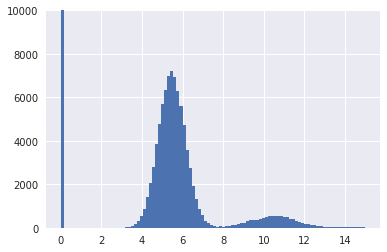

In [42]:
%matplotlib inline
plt.figure()
plt.hist(areas_height_from_cw,100,
         range=(0,15)
        );
# plt.semilogy()
plt.ylim(0,10000)
# plt.xlim(0.6,1)

In [13]:
# Find Centers and Sigmas of distributions
# does not assume population is Poisson distributed.
reload(thres)
area_mus, area_sigmas = thres.gauss_fit_results(pnr_height_from_cw,
                                          min_peak_sep=0.3, 
                                          threshold=None, 
                                          weighted=True)
np.savetxt(results_directory+'area_mus.dat',area_mus)
np.savetxt(results_directory+'area_sigmas.dat',area_sigmas)
print area_mus, area_sigmas

[ 0.54934832  1.05391623] [ 0.06668752  0.11809285]


In [14]:
# Generate Area Thresholds
th_areas = [(area_mus[i]-2*area_sigmas[i],area_mus[i]+2*area_sigmas[i]) for i,_ in enumerate(area_mus)]
np.savetxt(results_directory+'area_thresholds_single_diode_pulse_from_cw.dat', th_areas)
print th_areas

[(0.41597328359253183, 0.68272336486205898), (0.81773053415125307, 1.2901019186750755)]


In [13]:
# Or Load Centers, Sigmas and Area Thresholds 
area_mus = np.loadtxt(results_directory+'area_mus.dat')
area_sigmas = np.loadtxt(results_directory+'area_sigmas.dat')
th_areas = np.loadtxt(results_directory+'area_thresholds_single_diode_pulse_from_cw.dat')
print th_areas

[[ 0.41597328  0.68272336]
 [ 0.81773053  1.29010192]]


In [200]:
# print 'single photon amplitude: truncated distribution for prior' 
# print 'left limit = {}'.format((area_mus[1]-4*area_sigmas[1])/2/area_mus[0])
# print 'center = {}'.format((area_mus[1])/2/area_mus[0])
# print 'sigma = {}'.format((area_sigmas[1])/area_mus[0])
# print 'right limit = {}'.format((area_mus[1]+4*area_sigmas[1])/2/area_mus[0])

In [25]:
# Calculate overlap of Area Distribution between n=1 and n=2 traces.
from scipy.special import erf
def inside_prob(x,x0,sig0):
    "prob that data lies from -x to x"
    return erf((x-x0)/sig0/np.sqrt(2))
print 'dark count probability = {}%'.format((1-inside_prob(th_areas[1][0],area_mus[0],area_sigmas[0]))/2*100)
print 'efficiency = {}'.format((inside_prob(th_areas[1][0],area_mus[1],area_sigmas[1]))*100)

dark count probability = 0.00285513677888%
efficiency = -95.4499736104


In [26]:
plt.savefig(results_directory+'area_windowed_dtleft_200ns_dtright_700ns.pdf')

### Step 4a: Select 2-photon traces, or load

In [16]:
mask_2ph_cont = (areas_height_from_cw>th_areas[1][0])&(areas_height_from_cw<th_areas[1][1])
np.savetxt(results_directory+'mask_2ph_cont.dat', mask_2ph_cont)

In [14]:
mask_2ph_cont = np.loadtxt(results_directory+'mask_2ph_cont.dat').astype(bool)

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


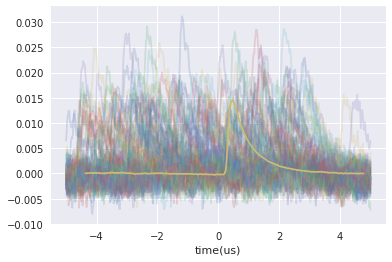

In [18]:
# Plots 2 Photons traces as a check
%matplotlib inline
plt.figure()
hpa.pplot(filelist_cont[mask_2ph_cont][0:1000], height_th, plot_every=10)
# plt.plot(time_f*1e6,signal_f, label='single photon model')
plt.legend()
# plt.xlim(0,1.5);
plt.plot(time_f*1e6+0.3, signal_f)
# plt.savefig(results_directory+'persist_cont.pdf')

### Define Priors for MCMC

In [15]:
# define amplitude sum distribution as n=2 area distribution normalised to n=1 mean area
sum_mu = area_mus[1]/area_mus[0]
sum_tau = 1.0/((area_sigmas[1]/area_mus[0])**2)
sum_a = th_areas[1][0]/area_mus[0]
sum_b = th_areas[1][1]/area_mus[0]
print sum_a, sum_mu, sum_b

1.4885465161 1.91848446593 2.34842241576


In [16]:
# define amplitude difference distribution as n=2 area distribution normalised to n=1 mean area, shifted to zero
diff_tau = 1.0/((area_sigmas[1]/area_mus[0])**2)
TwoPhoton_ThresWidth = (th_areas[1][1]-th_areas[1][0])
diff_a = -TwoPhoton_ThresWidth/2/area_mus[0]
diff_b = TwoPhoton_ThresWidth/2/area_mus[0]
print diff_a, diff_b

-0.429937949832 0.429937949832


In [32]:
#Calculate RMS Noise from n=0 traces
reload(hpa)
mask_noise_traces =  (areas_height_from_cw <= pnr_height_from_cw[1][1])
print mask_noise_traces
np.savetxt(results_directory+'mask_noise_traces.dat',mask_noise_traces)
sigma0 = np.mean([hpa.std_extr(f,height_th) for f in filelist_cont[mask_noise_traces][:1000]])
print sigma0

[ True  True  True ...,  True  True  True]
0.00183298303024


In [33]:
np.savetxt(results_directory+'sigma0.txt',[sigma0])

In [17]:
sigma0 = np.loadtxt(results_directory+'sigma0.txt')

### Create 2-photon model

In [18]:
# LEAST SQUARES - performs also MCMC within it
def one_pulse(x, x_offset=0, amplitude=1):
    """
    convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)

two_pulse_fit = Model(one_pulse, prefix='one_') + \
        Model(one_pulse, prefix='two_')

### Test on some traces
use gelman-rubin to check if 10 markkov chains converge.
https://pymc-devs.github.io/pymc/modelchecking.html

[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:     -1.4118e-06 (init=-1.452e-06)
    two_x_offset:     -1.2960e-06 (init=-9.68e-07)
    sum_amplitudes:    1.97757501 (init= 1.937669)
    diff_amplitudes:  -0.18650326 (init= 0)
    one_amplitude:     0.89553587  == '(sum_amplitudes+diff_amplitudes)/2'
    two_amplitude:     1.08203914  == '(sum_amplitudes-diff_amplitudes)/2'

arrival time difference = -115.83ns


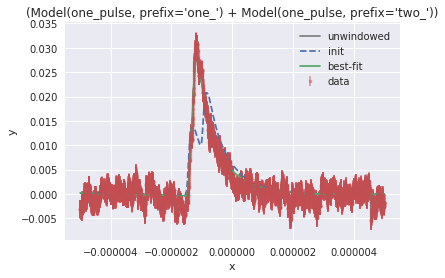

In [19]:
reload(pf6)
a, b, c = pf6.testcw(filelist_cont[mask_2ph_cont][0],
           t_initial,
           t_final,
          two_pulse_fit,
           one_pulse=one_pulse,
          sigma0=sigma0,    # signal noise
                               sum_mu=sum_mu, 
                               sum_tau=sum_tau, 
                               sum_a=sum_a,
                               sum_b=sum_b,
                               diff_tau=diff_tau,
                               diff_a=diff_a,
                               diff_b=diff_b, 
          sampling=1.2e4,
          burn=5e3,
          thin=20,
          height_th=height_th)

[-4.81999986 -3.78799989 -2.34799993 -1.28199996 -0.014       1.12199997
  2.53199993  3.6079999   4.67999987]
[ 3.53399944  3.2239994   2.24439986  0.45880023 -0.49600005 -1.17800012
 -1.93439983 -1.95920095 -2.03360058]
[ 1.12199997 -1.28199996 -0.014       2.53199993  4.67999987  3.6079999
 -2.34799993 -3.78799989 -4.81999986]
[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:     -1.2448e-06 (init=-1.173e-06)
    two_x_offset:      1.1292e-06 (init= 1.163e-06)
    sum_amplitudes:    1.68365306 (init= 1.937669)
    diff_amplitudes:  -0.16470662 (init= 0)
    one_amplitude:     0.75947321  == '(sum_amplitudes+diff_amplitudes)/2'
    two_amplitude:     0.92417984  == '(sum_amplitudes-diff_amplitudes)/2'

arrival time difference = -2374.05ns


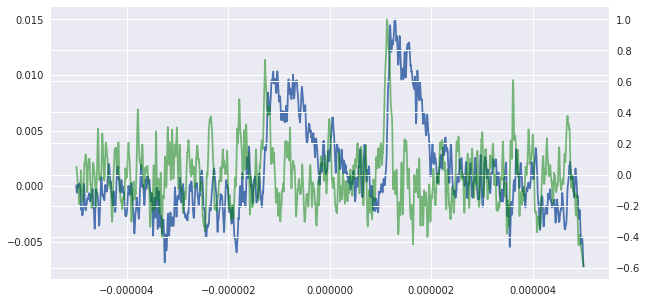

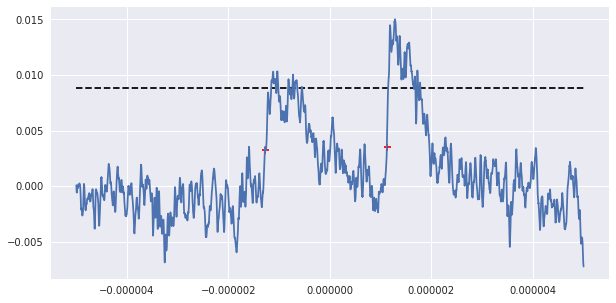

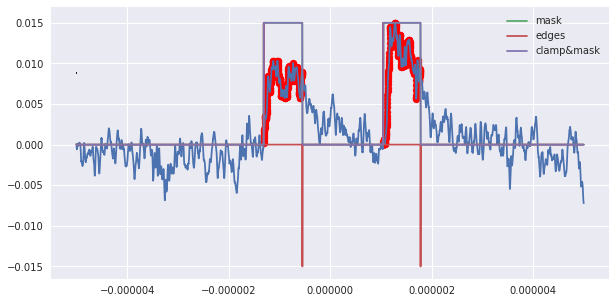

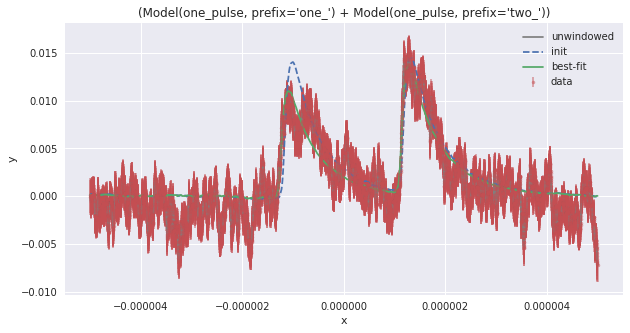

In [168]:
# Comparison between Fowler's triggering method and the SET-RESET method
reload(pd)
reload(pf)
i = 6
fname = filelist_cont[mask_2ph_cont][i]
simple_fname = fname.split('/')[-1].split('.trc')[0]
t,s = hpa.trace_extr(fname, height_th)
f, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(t,s)
ax2.plot(*pd.savdisc(t,s,61),color='green',alpha=0.5)
# plt.xlim(-2e-6,2e-6)
plt.savefig(results_directory+'fowler_diff_{}.pdf'.format(simple_fname))

pf.edges_by_diff(*hpa.trace_extr(fname, height_th),
                 height_th=height_th,
                 order=1,
                 filterpts=61,
                 thres=sigma0/(2*height_th),
                 min_dist=1000/2,
                 debug=True)
plt.savefig(results_directory+'fowler_diff_mindist_1us{}.pdf'.format(simple_fname))
[mask, clamp, edges, left_edges, right_edges] = pd.discriminator(t,s, 
                                                                  dt_left=0e-9,dt_right=0e-9, 
                                                                  height_th=height_th, 
                                                                  Plot=True, 
                                                                  method=2)
plt.savefig(results_directory+'srlatchrev_{}.pdf'.format(simple_fname))
reload(pf6)
a, b, c = pf6.testcw(fname,
           t_initial,
           t_final,
          two_pulse_fit,
           one_pulse=one_pulse,
          sigma0=sigma0,    # signal noise
                               sum_mu=sum_mu, 
                               sum_tau=sum_tau, 
                               sum_a=sum_a,
                               sum_b=sum_b,
                               diff_tau=diff_tau,
                               diff_a=diff_a,
                               diff_b=diff_b, 
          sampling=1.2e4,
          burn=5e3,
          thin=20,
          height_th=height_th)
plt.savefig(results_directory+'lmfit_{}.pdf'.format(simple_fname))

In [20]:
print a.init_values
print a.best_values

{'one_x_offset': -1.4519999589346355e-06, 'one_amplitude': 0.96883465529319845, 'two_amplitude': 0.96883465529319845, 'two_x_offset': -9.6799997262317441e-07}
{'one_x_offset': -1.4118300637831583e-06, 'one_amplitude': 0.89553587685914637, 'two_amplitude': 1.0820391417606343, 'two_x_offset': -1.2959998770578437e-06}


In [20]:
# extract fit results, initial and final, from lmfit object.
# works in pandas which concats diff datatypes easily.
def results_extr(r):
    """
    Extracts initial, final values from lmfit object.
    """
    results_summary=[]
    keys=[]
    for i,key in enumerate(r.init_values.keys()):
        results_summary.append(float(r.init_values.values()[i]))
        keys.append(key+'_init')
    for i,key in enumerate(r.best_values.keys()):
        results_summary.append(r.best_values.values()[i])
        keys.append(key+'_fitted')
    return results_summary, keys

def results_packager(results_summary, keys, fname, mcmc_flag, unequal_edges):
    """
    Concatinates fit results and other flags together in a pandas row.
    """
#     r,keys = results_extr(a)
    r = np.array(results_summary).reshape(1,8)
    keys = np.array(keys).reshape(8,)
    p = pandas.DataFrame(r,columns=keys)
    q = pandas.DataFrame([[fname, mcmc_flag, unequal_edges]],
                         columns=['fname','mcmc_flag','unequal_edges'])
    return pandas.concat([q,p], axis=1)

def results_saver(outfile, results_summary, keys, fname, mcmc_flag, unequal_edges):
    """
    Append new pandas row to an outfile.
    """
    with open(outfile,'a+') as f:
        if not f.read(1):
            print 'creating new file'
            header = True
        else:
            header = False
        results_packager(results_summary, keys, fname, mcmc_flag, unequal_edges).to_csv(f,header=header)
    f.close()

In [40]:
from timeit import Timer
t = Timer(lambda: results_packager(*results_extr(a),fname='fname',mcmc_flag=True,unequal_edges=False))
print t.timeit(number=1)
# df = results_packager(*results_extr(a),fname='fname',mcmc_flag=True,unequal_edges=False)
# (df['one_x_offset_init']-df['two_x_offset_init'])*1e9

0.009761095047


[array([False, False, False, ...,  True,  True,  True], dtype=bool), array([False, False, False, ..., False, False, False], dtype=bool), array([0, 0, 0, ..., 0, 0, 0]), array([4338]), array([], dtype=int64)]


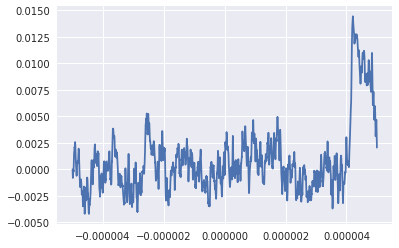

In [203]:
# Troubleshoot discriminator
reload(pd)
t,s = hpa.trace_extr(directories[0]+'C2doubles02928'+'.trc', height_th)
[mask, clamp, edges, left_edges, right_edges] = pd.discriminator(t,s, 
                                                                  dt_left=300e-9,dt_right=1400e-9, 
                                                                  height_th=height_th, 
                                                                  Plot=False, 
                                                                  method=2)
window = mask&clamp
plt.figure()
plt.plot(t,s)
# 
plt.scatter(t[window],s[window],color='red')
# plt.axvline(t[left_edges[0]])
# plt.axvline(t[right_edges[-1]])
# t_left = t[left_edges[0]]
# t_right = t[right_edges[-1]]
# plt.scatter(t[(window)&(t_left<t)&(t<t_right)],
#             s[(window)&(t_left<t)&(t<t_right)],color='green')
print [mask, clamp, edges, left_edges, right_edges]

# MCMC Optimisation

### Step 5.1: edit precision desired through q, r

In [ ]:
# Perform Diagnostic on a sample trace to determine the recommended fitting params
pymc_diagnostic = pymc.raftery_lewis(b, q=0.025, r=0.01);
pymc_diagnostic
# print np.array([pymc_diagnostic[i] for i in pymc_diagnostic.keys()[1:]])

# MultiProcess 2 photon traces 

### Step 6: 
### * Edit t_initial and t_final windows to save convergence time - warning: too short a time period will affect background estimation accuracy!
### * Update sampling, burn and thin based on optimised parameters in Step 5

In [21]:
# Initialise telegram to message progress
from telegram.bot import Bot
uid='304462759'
token='351459283:AAH5Gyojsh69DtecyxFuCm_Rha4i8QNMSZo'
sender_bot=Bot(token=token)
sender_bot.sendMessage(chat_id=uid,text='testing')

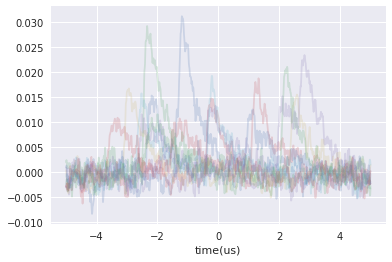

In [46]:
hpa.pplot(filelist_cont[mask_2ph_cont][:100],height_th)

In [162]:
reload(hpa)
reload(pf6)
import multiprocess as mp
from multiprocess import Pool
tasks = np.array(filelist_cont[mask_2ph_cont][:])
print len(tasks)
# tasks = directories[0]+np.array(fnames)+'.trc'
counter = mp.Value('i',0)
has_header = mp.Value("b", True)
p = Pool(24)

def fit_two_poolable(file):
    try:
        fname = file.split('/')[-1].split('.trc')[0]
        time, signal = hpa.trace_extr(file, h_th=height_th, t_initial=None, t_final=None)
        result, mcmc_flag, unequal_edges = pf6.fit_two_cw(time,signal,
                                                        two_pulse_fit,
                                                        one_pulse=one_pulse,
                                                        sigma0=sigma0,    # signal noise
                                                               sum_mu=sum_mu, 
                                                               sum_tau=sum_tau, 
                                                               sum_a=sum_a,
                                                               sum_b=sum_b,
                                                               diff_tau=diff_tau,
                                                               diff_a=diff_a,
                                                               diff_b=diff_b, 
                                                      sampling=1.2e4,
                                                      burn=5e3,
                                                      thin=20,
                                                      height_th=height_th)
        # Extract results
        results_summary, keys = results_extr(result)
        df = results_packager(results_summary, keys, fname, mcmc_flag, unequal_edges)
        # Sends Telegram Message to Update Status
        counter.value+=1
        times_toupdate = 20
        text_tosend = '\nProcess finished:'+ '%.1f'%(counter.value/len(tasks)*100) + "%"
        print text_tosend
        try:
            if counter.value % int(len(tasks)/times_toupdate) == 0:
                sender_bot.sendMessage(chat_id=uid,text=text_tosend)
        except:
            pass
        
        # Extracts useful data for saving
        return df
    except:
        print fname #if file is corrupt

9757

Process finished:0.0%

Process finished:0.0%

Process finished:0.0%

Process finished:0.1%
Process finished:0.0%
Process finished:0.1%


Process finished:0.1%


Process finished:0.1%

Process finished:0.1%

Process finished:0.1%

Process finished:0.1%
Process finished:0.1%


Process finished:0.1%

Process finished:0.2%

Process finished:0.1%

Process finished:0.2%

Process finished:0.2%

Process finished:0.2%

Process finished:0.2%
Process finished:0.2%


Process finished:0.2%
Process finished:0.2%


Process finished:0.2%
Process finished:0.2%

C2doubles01007

Process finished:0.3%
Process finished:0.3%
Process finished:0.3%
Process finished:0.3%




Process finished:0.3%
Process finished:0.3%

Process finished:0.3%

Process finished:0.3%


Process finished:0.3%

Process finished:0.4%

Process finished:0.3%

Process finished:0.4%

Process finished:0.4%

Process finished:0.4%

Process finished:0.4%

Process finished:0.4%

Process finished:0.4%

Process finished:0.4%

Process finis

Process finished:7.2%


Process finished:7.2%
Process finished:7.2%


Process finished:7.2%
Process finished:7.2%



Process finished:7.2%
Process finished:7.2%
Process finished:7.2%


Process finished:7.2%
Process finished:7.3%


Process finished:7.3%

Process finished:7.3%
C2doubles29845

Process finished:7.3%

Process finished:7.3%

Process finished:7.3%

Process finished:7.3%
Process finished:7.3%
Process finished:7.3%
Process finished:7.3%




Process finished:7.4%

Process finished:7.4%

Process finished:7.4%
Process finished:7.4%


Process finished:7.4%

Process finished:7.4%

Process finished:7.4%

Process finished:7.4%

Process finished:7.4%

Process finished:7.4%

Process finished:7.5%

Process finished:7.5%

Process finished:7.5%
Process finished:7.5%

Process finished:7.5%


Process finished:7.5%

Process finished:7.5%
Process finished:7.5%

Process finished:7.5%


Process finished:7.5%

Process finished:7.6%
Process finished:7.6%

Process finished:7.6%
Process finished:7.6

Process finished:14.2%


Process finished:14.2%

Process finished:14.2%
Process finished:14.2%


Process finished:14.3%

Process finished:14.2%
Process finished:14.3%


Process finished:14.3%
Process finished:14.3%


Process finished:14.3%
Process finished:14.3%
Process finished:14.3%

Process finished:14.3%



Process finished:14.3%

Process finished:14.3%
Process finished:14.4%

Process finished:14.4%


Process finished:14.4%

Process finished:14.4%

Process finished:14.4%
Process finished:14.4%


Process finished:14.4%

Process finished:14.4%

Process finished:14.4%

Process finished:14.5%
Process finished:14.5%


Process finished:14.5%

Process finished:14.5%

Process finished:14.5%
C2doubles58810

Process finished:14.5%
Process finished:14.5%


Process finished:14.5%

Process finished:14.5%
Process finished:14.5%

Process finished:14.6%

Process finished:14.6%


Process finished:14.6%
Process finished:14.6%


Process finished:14.6%
Process finished:14.6%
Process finished:14.6%





Process finished:21.1%


Process finished:21.1%

Process finished:21.1%

Process finished:21.1%
Process finished:21.1%


Process finished:21.1%
Process finished:21.2%

Process finished:21.2%

Process finished:21.2%


Process finished:21.2%

Process finished:21.2%

Process finished:21.2%

Process finished:21.2%

Process finished:21.2%
Process finished:21.2%

Process finished:21.2%


Process finished:21.3%

Process finished:21.3%

Process finished:21.3%
Process finished:21.3%


Process finished:21.3%
Process finished:21.3%


Process finished:21.3%

Process finished:21.3%

Process finished:21.3%

Process finished:21.4%

Process finished:21.3%

Process finished:21.4%
Process finished:21.4%
Process finished:21.4%


Process finished:21.4%


Process finished:21.4%

Process finished:21.4%

Process finished:21.4%

Process finished:21.5%
Process finished:21.4%


Process finished:21.5%

Process finished:21.5%

Process finished:21.5%

Process finished:21.5%

Process finished:21.5%

Process finishe

Process finished:24.5%
C2doubles97845


Process finished:24.6%

Process finished:24.6%

Process finished:24.6%
Process finished:24.6%


Process finished:24.6%

Process finished:24.6%

Process finished:24.6%

Process finished:24.6%
Process finished:24.6%


Process finished:24.6%
Process finished:24.7%


Process finished:24.7%
Process finished:24.7%


Process finished:24.7%
Process finished:24.7%
Process finished:24.7%
Process finished:24.7%




Process finished:24.7%

Process finished:24.8%
Process finished:24.7%

Process finished:24.8%


Process finished:24.8%

Process finished:24.8%

Process finished:24.8%


Process finished:24.8%
Process finished:24.8%

Process finished:24.8%
Process finished:24.8%


Process finished:24.8%

Process finished:24.9%

Process finished:24.9%

Process finished:24.9%

Process finished:24.9%

Process finished:24.9%

Process finished:24.9%

Process finished:24.9%

Process finished:24.9%
Process finished:24.9%


Process finished:24.9%

Process finished:25.0%



Process finished:31.4%

Process finished:31.4%

Process finished:31.4%
Process finished:31.4%

Process finished:31.4%


Process finished:31.4%

Process finished:31.5%

Process finished:31.5%

Process finished:31.5%

Process finished:31.5%

Process finished:31.5%

Process finished:31.5%
C2doubles_more26367

Process finished:31.5%

Process finished:31.5%

Process finished:31.5%
Process finished:31.5%


Process finished:31.6%
Process finished:31.6%


Process finished:31.6%

Process finished:31.6%

Process finished:31.6%
Process finished:31.6%


Process finished:31.6%
Process finished:31.6%


Process finished:31.6%

Process finished:31.6%

Process finished:31.7%
Process finished:31.7%


Process finished:31.7%
Process finished:31.7%


Process finished:31.7%C2doubles_more27381


Process finished:31.7%

Process finished:31.7%
Process finished:31.7%
Process finished:31.7%


Process finished:31.8%
Process finished:31.8%



Process finished:31.8%

Process finished:31.8%

Process finished:31.8%



Process finished:38.2%

Process finished:38.2%
Process finished:38.2%


Process finished:38.3%
Process finished:38.2%
Process finished:38.3%


Process finished:38.3%

Process finished:38.3%
Process finished:38.3%



Process finished:38.3%

Process finished:38.3%

Process finished:38.3%
C2doubles_more54190

Process finished:38.3%

Process finished:38.4%
Process finished:38.4%


Process finished:38.4%

Process finished:38.4%

Process finished:38.4%

Process finished:38.4%

Process finished:38.4%

Process finished:38.4%
Process finished:38.4%


Process finished:38.4%
Process finished:38.5%


Process finished:38.5%

Process finished:38.5%
Process finished:38.5%


Process finished:38.5%

Process finished:38.5%

Process finished:38.5%

Process finished:38.5%
Process finished:38.5%


Process finished:38.6%

Process finished:38.5%
Process finished:38.6%


Process finished:38.6%
Process finished:38.6%


Process finished:38.6%

Process finished:38.6%

Process finished:38.6%
Process finished:38.6

Process finished:45.0%

Process finished:45.0%

Process finished:45.0%

Process finished:45.0%

Process finished:45.0%
Process finished:45.1%
Process finished:45.1%



Process finished:45.1%

Process finished:45.1%

Process finished:45.1%

Process finished:45.1%

Process finished:45.1%

Process finished:45.1%

Process finished:45.1%

Process finished:45.1%

Process finished:45.2%

Process finished:45.2%

Process finished:45.2%

Process finished:45.2%

Process finished:45.2%

Process finished:45.2%

Process finished:45.2%
Process finished:45.2%

Process finished:45.2%


Process finished:45.2%

Process finished:45.3%
Process finished:45.3%
Process finished:45.3%



Process finished:45.3%

Process finished:45.3%

Process finished:45.3%

Process finished:45.3%

Process finished:45.3%
Process finished:45.3%


Process finished:45.4%

Process finished:45.4%

Process finished:45.4%

Process finished:45.4%

Process finished:45.4%

Process finished:45.4%
Process finished:45.4%


Process finished

Process finished:51.9%
Process finished:51.9%
Process finished:51.9%



Process finished:51.9%
Process finished:51.9%


Process finished:51.9%

Process finished:51.9%

Process finished:52.0%
Process finished:52.0%


Process finished:52.0%

Process finished:52.0%

Process finished:52.0%
Process finished:52.0%
Process finished:52.0%



Process finished:52.0%

Process finished:52.0%
Process finished:52.0%


Process finished:52.1%

Process finished:52.1%

Process finished:52.1%

Process finished:52.1%
Process finished:52.1%
Process finished:52.1%


Process finished:52.1%


Process finished:52.1%

Process finished:52.1%

Process finished:52.2%

Process finished:52.1%

Process finished:52.2%
Process finished:52.2%


Process finished:52.2%

Process finished:52.2%

Process finished:52.2%

Process finished:52.2%

Process finished:52.2%

Process finished:52.2%
Process finished:52.2%


Process finished:52.3%

Process finished:52.3%

Process finished:52.3%

Process finished:52.3%

Process finished

Process finished:58.7%


Process finished:58.7%

Process finished:58.8%

Process finished:58.8%
Process finished:58.8%


Process finished:58.8%
Process finished:58.8%


Process finished:58.8%

Process finished:58.8%

Process finished:58.8%
Process finished:58.8%

C2doubles_more_more40599

Process finished:58.9%
Process finished:58.9%
Process finished:58.9%

Process finished:58.9%


Process finished:58.9%


Process finished:58.9%
Process finished:58.9%


Process finished:58.9%

Process finished:58.9%

Process finished:58.9%

Process finished:59.0%

Process finished:59.0%

Process finished:59.0%

Process finished:59.0%

Process finished:59.0%

Process finished:59.0%

Process finished:59.0%
Process finished:59.0%


Process finished:59.0%
Process finished:59.0%


Process finished:59.1%

Process finished:59.1%

Process finished:59.1%

Process finished:59.1%

Process finished:59.1%

Process finished:59.1%
Process finished:59.1%


Process finished:59.1%

Process finished:59.1%
Process finishe


C2doubles_more_more53714

Process finished:62.1%

Process finished:62.1%

Process finished:62.2%
Process finished:62.2%


Process finished:62.2%

Process finished:62.2%
Process finished:62.2%

Process finished:62.2%

Process finished:62.2%

Process finished:62.2%

Process finished:62.2%
Process finished:62.2%



Process finished:62.3%

Process finished:62.3%

Process finished:62.3%

Process finished:62.3%
Process finished:62.3%

Process finished:62.3%

Process finished:62.3%


Process finished:62.3%

Process finished:62.3%
Process finished:62.3%

Process finished:62.4%


Process finished:62.4%
Process finished:62.4%


Process finished:62.4%

Process finished:62.4%
Process finished:62.4%

Process finished:62.4%


Process finished:62.4%
Process finished:62.4%

Process finished:62.5%

Process finished:62.4%

Process finished:62.5%


Process finished:62.5%
Process finished:62.5%


Process finished:62.5%

Process finished:62.5%

Process finished:62.5%

Process finished:62.5%

Process finis

Process finished:69.0%


Process finished:69.0%

Process finished:69.0%
Process finished:69.0%


Process finished:69.0%
Process finished:69.1%


Process finished:69.1%

Process finished:69.1%

Process finished:69.1%
Process finished:69.1%


Process finished:69.1%

Process finished:69.1%

Process finished:69.1%

Process finished:69.1%

Process finished:69.2%

Process finished:69.2%
Process finished:69.2%

Process finished:69.2%

Process finished:69.2%

Process finished:69.2%


Process finished:69.2%
Process finished:69.2%


Process finished:69.3%

Process finished:69.2%
Process finished:69.2%


Process finished:69.3%

Process finished:69.3%

Process finished:69.3%

Process finished:69.3%

Process finished:69.3%

Process finished:69.3%

Process finished:69.3%
C2doubles_more_more83686

Process finished:69.3%

Process finished:69.3%

Process finished:69.4%

Process finished:69.4%

Process finished:69.4%

Process finished:69.4%

Process finished:69.4%

Process finished:69.4%

Process finish

Process finished:75.8%


Process finished:75.9%

Process finished:75.9%
Process finished:75.9%


Process finished:75.9%

Process finished:75.9%
Process finished:75.9%
Process finished:75.9%

Process finished:75.9%



Process finished:75.9%

Process finished:75.9%
Process finished:76.0%


Process finished:76.0%
C2doubles_more_more_more10298

Process finished:76.0%
Process finished:76.0%


Process finished:76.0%
Process finished:76.0%


Process finished:76.0%
Process finished:76.0%

Process finished:76.1%
Process finished:76.0%



Process finished:76.0%

Process finished:76.1%

Process finished:76.1%

Process finished:76.1%

Process finished:76.1%

Process finished:76.1%

Process finished:76.1%C2doubles_more_more_more11441

C2doubles_more_more_more10971

Process finished:76.1%

Process finished:76.1%

Process finished:76.2%

Process finished:76.2%

Process finished:76.2%

Process finished:76.2%

Process finished:76.2%
Process finished:76.2%


Process finished:76.2%
Process finished:76.2%


Process finished:82.7%

Process finished:82.7%
Process finished:82.7%


Process finished:82.7%

Process finished:82.7%
Process finished:82.8%


Process finished:82.8%
Process finished:82.8%


Process finished:82.8%

Process finished:82.8%

Process finished:82.8%

Process finished:82.8%
C2doubles_more_more_more40183

Process finished:82.8%

Process finished:82.8%

Process finished:82.8%
Process finished:82.9%


Process finished:82.9%
Process finished:82.9%


Process finished:82.9%

Process finished:82.9%

Process finished:82.9%
Process finished:82.9%


Process finished:82.9%
Process finished:82.9%


Process finished:82.9%

Process finished:83.0%

Process finished:83.0%C2doubles_more_more_more40429


Process finished:83.0%
Process finished:83.0%


Process finished:83.0%
Process finished:83.0%
Process finished:83.0%



Process finished:83.0%

Process finished:83.0%

Process finished:83.0%

Process finished:83.1%
Process finished:83.1%


Process finished:83.1%
Process finished:83.1%


Pro

Process finished:89.4%

Process finished:89.4%
Process finished:89.4%
Process finished:89.4%



Process finished:89.4%

Process finished:89.5%

Process finished:89.5%

Process finished:89.5%

Process finished:89.5%
Process finished:89.5%


Process finished:89.5%

Process finished:89.5%

Process finished:89.5%

Process finished:89.5%

Process finished:89.6%

Process finished:89.6%

Process finished:89.5%
Process finished:89.6%
Process finished:89.6%



Process finished:89.6%
Process finished:89.6%
Process finished:89.6%


Process finished:89.6%


Process finished:89.6%

Process finished:89.6%

Process finished:89.7%C2doubles_more_more_more67877


Process finished:89.7%

Process finished:89.7%
Process finished:89.7%


Process finished:89.7%

Process finished:89.7%

Process finished:89.7%
Process finished:89.7%


Process finished:89.8%

Process finished:89.7%

Process finished:89.8%
Process finished:89.8%

Process finished:89.8%


Process finished:89.8%

Process finished:89.8%
Process fin

Process finished:96.2%
Process finished:96.2%

Process finished:96.2%


Process finished:96.2%
C2doubles_more_more_more94131

Process finished:96.2%

Process finished:96.2%

Process finished:96.3%
Process finished:96.3%


Process finished:96.3%

Process finished:96.3%
Process finished:96.3%

Process finished:96.3%


Process finished:96.3%

Process finished:96.3%

Process finished:96.4%

Process finished:96.3%
Process finished:96.4%


Process finished:96.4%

Process finished:96.4%

Process finished:96.4%
Process finished:96.4%


Process finished:96.4%
C2doubles_more_more_more94920

Process finished:96.4%

Process finished:96.4%

Process finished:96.4%

Process finished:96.5%

Process finished:96.5%

Process finished:96.5%
Process finished:96.5%

Process finished:96.5%
Process finished:96.5%

Process finished:96.5%



Process finished:96.5%

Process finished:96.5%

Process finished:96.5%
Process finished:96.6%


Process finished:96.6%

Process finished:96.6%

Process finished:96.6%

Proc

In [83]:
# print tasks[:10]
# df = p.map(fit_two_poolable,tasks[0:1])[0]
# print df

In [163]:
def run_fit_two_poolable(outfile,tasks):
    """
    Append new pandas row to an outfile.
    """
    counter = mp.Value('i',0)
    with open(outfile,'a+') as f:
        df = p.map(fit_two_poolable,tasks[0:1])
        df[0].to_csv(f,header=True)
        for df in p.imap(fit_two_poolable,tasks[1:]):
            try:
                df.to_csv(f,header=False)
            except:
                pass

In [164]:
reload(pf6)
run_fit_two_poolable(results_directory+'results_lmfit_only_sigma0wt_fullsig_powell_again.csv',tasks)

# Import Results
remove nan records: warning! investigate why they are nan in the first place!

In [176]:
data = pandas.read_csv(results_directory+'results_lmfit_only_sigma0wt_fullsig_powell_again.csv')
df = data[data['Unnamed: 0']!=np.nan]
df = df.drop_duplicates()
print data[-1:];
df['mcmc_flag'] = df['mcmc_flag'].astype('bool')
df['unequal_edges'] = df['unequal_edges'].astype('bool')
print df.dtypes

      Unnamed: 0                          fname  mcmc_flag  unequal_edges  \
9542           0  C2doubles_more_more_more99885      False          False   

      one_x_offset_init  one_amplitude_init  two_amplitude_init  \
9542          -0.000002            0.968835            0.968835   

      two_x_offset_init  one_x_offset_fitted  one_amplitude_fitted  \
9542          -0.000001            -0.000002              1.035374   

      two_amplitude_fitted  two_x_offset_fitted  
9542              0.952772            -0.000001  
Unnamed: 0                int64
fname                    object
mcmc_flag                  bool
unequal_edges              bool
one_x_offset_init       float64
one_amplitude_init      float64
two_amplitude_init      float64
two_x_offset_init       float64
one_x_offset_fitted     float64
one_amplitude_fitted    float64
two_amplitude_fitted    float64
two_x_offset_fitted     float64
dtype: object


In [31]:
#for MCMC and lmfit
df['one_x_offset']=df['mcmc_flag']*df['one_x_offset_init']+~df['mcmc_flag']*df['one_x_offset_fitted']
df['two_x_offset']=df['mcmc_flag']*df['two_x_offset_init']+~df['mcmc_flag']*df['two_x_offset_fitted']
df['one_amplitude']=df['mcmc_flag']*df['one_amplitude_init']+~df['mcmc_flag']*df['one_amplitude_fitted']
df['two_amplitude']=df['mcmc_flag']*df['two_amplitude_init']+~df['mcmc_flag']*df['two_amplitude_fitted']
df['g2'] = df['one_x_offset']-df['two_x_offset']

In [177]:
#for lmfit only runs
df['one_x_offset']=df['one_x_offset_fitted']
df['two_x_offset']=df['two_x_offset_fitted']
df['one_amplitude']=df['one_amplitude_fitted']
df['two_amplitude']=df['two_amplitude_fitted']
df['diff'] = df['one_amplitude']-df['two_amplitude']
df['sum'] = df['one_amplitude']+df['two_amplitude']
df['g2'] = df['one_x_offset']-df['two_x_offset']

In [188]:
# filenames of traces we want to take a closer look
# fnames = np.array(df[(df['two_amplitude']-df['two_amplitude_init']).abs()<0.001]['fname'])
fnames = np.array(df[(df['g2'].abs()>0.9e-6)&(df['g2'].abs()<1e-6)]['fname'])
print fnames

['C2doubles02617' 'C2doubles02722' 'C2doubles05847' 'C2doubles06156'
 'C2doubles07805' 'C2doubles09225' 'C2doubles09293' 'C2doubles09460'
 'C2doubles09619' 'C2doubles14677' 'C2doubles19009' 'C2doubles20141'
 'C2doubles21936' 'C2doubles24577' 'C2doubles25147' 'C2doubles26658'
 'C2doubles26685' 'C2doubles26753' 'C2doubles26762' 'C2doubles28515'
 'C2doubles31855' 'C2doubles32425' 'C2doubles33036' 'C2doubles37935'
 'C2doubles39065' 'C2doubles42182' 'C2doubles43482' 'C2doubles44284'
 'C2doubles44887' 'C2doubles47924' 'C2doubles50226' 'C2doubles54277'
 'C2doubles54566' 'C2doubles55712' 'C2doubles56753' 'C2doubles57317'
 'C2doubles57359' 'C2doubles58683' 'C2doubles59855' 'C2doubles59955'
 'C2doubles64743' 'C2doubles70376' 'C2doubles74586' 'C2doubles74963'
 'C2doubles76646' 'C2doubles77534' 'C2doubles77947' 'C2doubles81372'
 'C2doubles81930' 'C2doubles85897' 'C2doubles87490' 'C2doubles89068'
 'C2doubles89574' 'C2doubles89958' 'C2doubles90197' 'C2doubles91937'
 'C2doubles95204' 'C2doubles98041'

In [94]:
# for i,f in enumerate(directories[0]+fnames+'.trc'):
#     try:
#         plt.figure()
#         plt.title('{}\n{}'.format(i,f))
#         plt.plot(*hpa.trace_extr(f,height_th))
#     except:
#         pass


In [95]:
# plt.figure()
# plt.scatter(df['g2'].abs()*1e9,df['mcmc_flag'])
# plt.xlim(100,700)

(-4.6567753522499996e-06, 3.3267952118400002e-06)

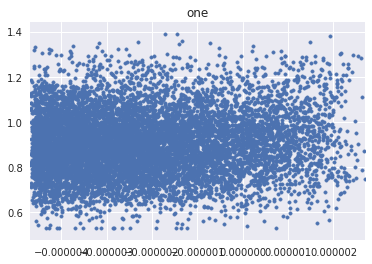

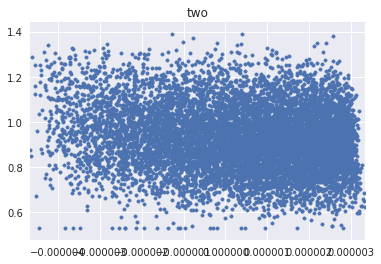

In [170]:
plt.figure()
plt.title('one')
plt.scatter(df['one_x_offset'],df['one_amplitude'],marker='.')
plt.xlim(np.min(df['one_x_offset']),np.max(df['one_x_offset']))
plt.figure()
plt.title('two')
plt.scatter(df['two_x_offset'],df['two_amplitude'],marker='.')
plt.xlim(np.min(df['two_x_offset']),np.max(df['two_x_offset']))

[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:      2.6799e-07 (init= 2.3e-07)
    two_x_offset:      1.2562e-06 (init= 1.374e-06)
    sum_amplitudes:    2.24506356 (init= 1.937669)
    diff_amplitudes:   0.23538487 (init= 0)
    one_amplitude:     1.24022421  == '(sum_amplitudes+diff_amplitudes)/2'
    two_amplitude:     1.00483934  == '(sum_amplitudes-diff_amplitudes)/2'

arrival time difference = -988.16ns


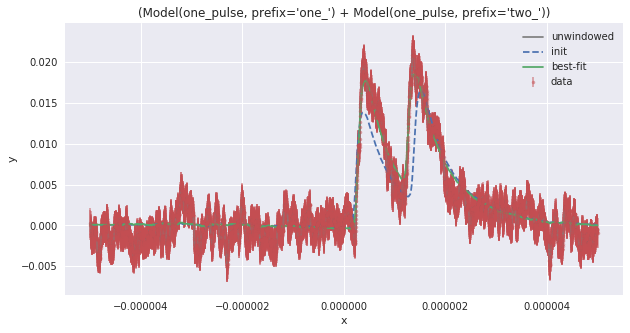

In [194]:
reload(pf6)
a, b, c = pf6.testcw(directories[0]+fnames[2]+'.trc',
           t_initial,
           t_final,
          two_pulse_fit,
           one_pulse=one_pulse,
          sigma0=sigma0,    # signal noise
                               sum_mu=sum_mu, 
                               sum_tau=sum_tau, 
                               sum_a=sum_a,
                               sum_b=sum_b,
                               diff_tau=diff_tau,
                               diff_a=diff_a,
                               diff_b=diff_b, 
          sampling=1.2e4,
          burn=5e3,
          thin=20,
          height_th=height_th)
plt.savefig(results_directory+'lmfit_powell_method.pdf')

In [121]:
fnames[0]

'C2doubles00682'

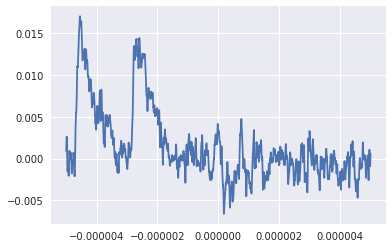

In [187]:
# pprint.pprint(df[df['fname']==fnames[0]])
plt.figure()
plt.plot(*hpa.trace_extr(directories[0]+'C2doubles02939'+'.trc',height_th))

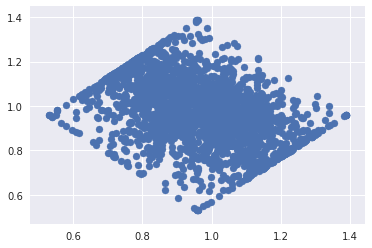

In [188]:
plt.figure()
plt.scatter(results_csv['one_amplitude_init'][~mask],results_csv['two_amplitude_init'][~mask])

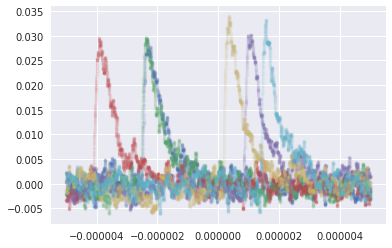

In [251]:
plt.figure()
for i in np.arange(6):
    for j in np.arange(len(directories)):
        try:
            plt.plot(*hpa.trace_extr(directories[j]+fnames[i]+'.trc',h_th=height_th),alpha=0.1, marker='.')
        except:
            pass

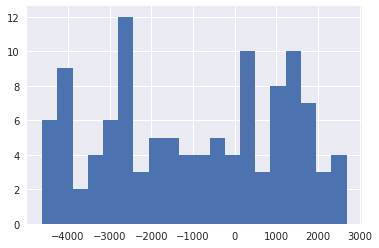

In [252]:
plt.figure()
plt.hist(results_csv[mask]['one_x_offset_init']*1e9,20);

### Check Results / Pickled Results

In [219]:
processed_cont = pf.extract(results_formatted_cont)

In [12]:
print results_formatted_cont[0].init_values
print results_formatted_cont[0].values

{'one_x_offset': -4.3420628157872983e-06, 'one_amplitude': 1, 'two_amplitude': 1, 'two_x_offset': 1.6499370147473684e-06}
{'one_x_offset': -4.3420628157872983e-06, 'one_amplitude': 0.99045215885822446, 'two_amplitude': 0.87663608712173557, 'two_x_offset': 1.6499370147473684e-06}


In [13]:
one_x_offsets=[]
two_x_offsets=[]
one_amplitudes=[]
two_amplitudes=[]
for i, r in enumerate(results_formatted_cont):
    if mcmc_flags[i]==True:
        one_x_offsets.append(r.init_values['one_x_offset'])
        two_x_offsets.append(r.init_values['two_x_offset'])
        one_amplitudes.append(r.init_values['one_amplitude'])
        two_amplitudes.append(r.init_values['two_amplitude'])
    if mcmc_flags[i]==False:
        one_x_offsets.append(r.values['one_x_offset'])
        two_x_offsets.append(r.values['two_x_offset'])
        one_amplitudes.append(r.values['one_amplitude'])
        two_amplitudes.append(r.values['two_amplitude'])
one_x_offsets=np.array(one_x_offsets)
two_x_offsets=np.array(two_x_offsets)
one_amplitudes=np.array(one_amplitudes)
two_amplitudes=np.array(two_amplitudes)

In [14]:
abs_taus_cont = np.abs(one_x_offsets-two_x_offsets)*1e9

## Absolute Time Separation

(642.15590849227362, 59.603885232692733)
fwhm = 140.367149723


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


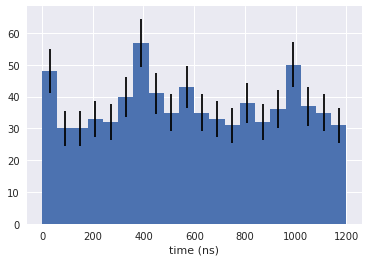

In [15]:
%matplotlib inline
mask_max_amp = np.minimum(one_amplitudes,two_amplitudes)>0.6
freq, bins = np.histogram(abs_taus_cont, 
                          bins=int(1200/60), 
                          range=(0,1200))
bins = bins[:-1]+np.diff(bins)[0]/2

plt.figure('arrival times _cont')
# plt.hist(abs_taus_cont, 20, range=(100,250), align='centre');
plt.bar(bins,freq,align='center',width=np.diff(bins)[0], yerr=np.sqrt(freq))
plt.xlabel('time (ns)')
plt.ylim(0,np.max(freq)*1.2)
# plt.ylim(0, 1000)
# plt.savefig(results_directory+'arrival_times_cont.pdf')
reload(sp)
# sp.FWHM(bins, freq, plot=True)
(m,s) = norm.fit(abs_taus_cont[(abs_taus_cont>550)&(abs_taus_cont<750)])
print (m,s)
print 'fwhm = {}'.format(2.355*s)

## Plot anomalies

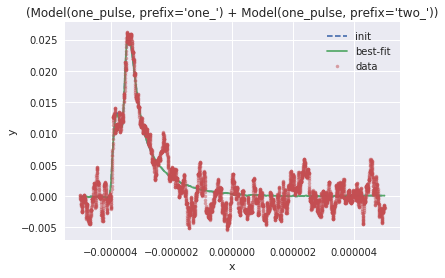

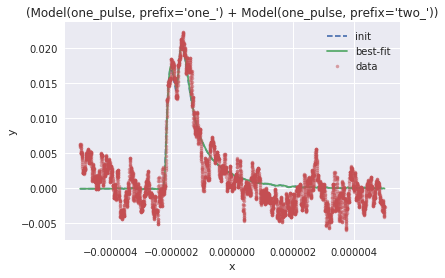

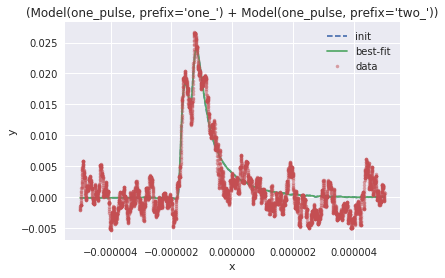

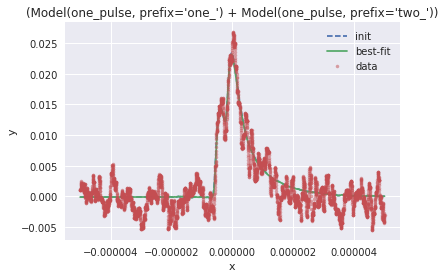

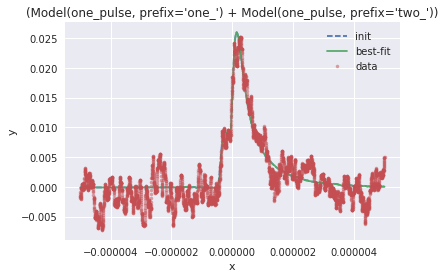

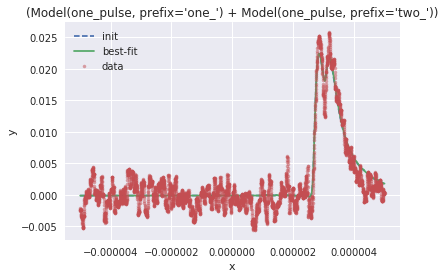

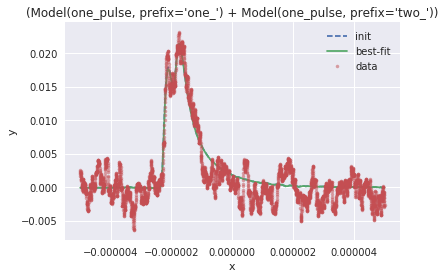

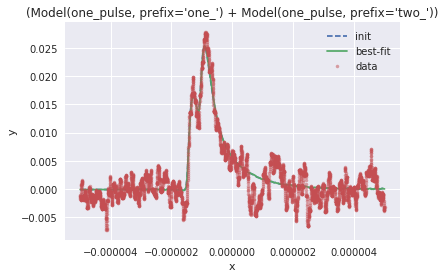

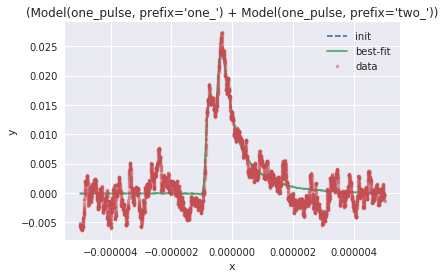

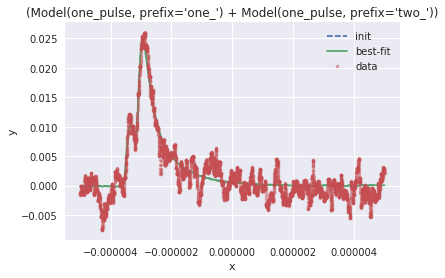

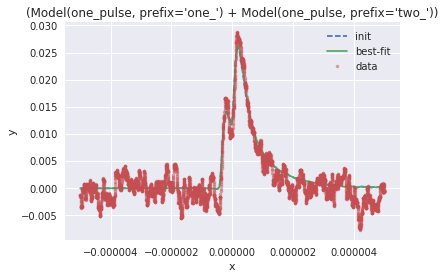

In [75]:
%matplotlib inline
mask = (abs_taus_cont>395)&(abs_taus_cont<405)
# print len(results_formatted_cont)
# print len(mask)
for i in np.arange(np.sum(mask)):
    plt.figure()
    np.array(results_formatted_cont)[mask][i].plot_fit(data_kws={'marker':".",'alpha':0.5})
    plt.savefig('abs_tau_395_to_405_ns_plots'+'/'+str(abs_taus_cont[mask][i])+'.pdf')

## Time Separation

In [16]:
taus_cont = (two_x_offsets-one_x_offsets)*1e9

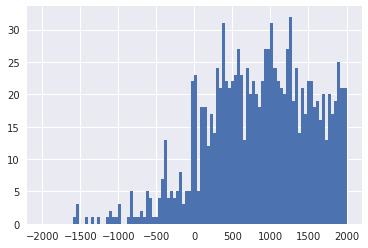

In [17]:
%matplotlib inline
plt.figure()
plt.hist((taus_cont),int(4000/40),range=(-2000,2000));
# plt.ylim(0,200)

## Separation vs Maximum or Sum of Amplitudes

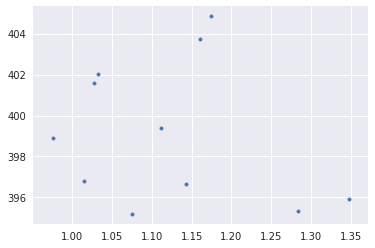

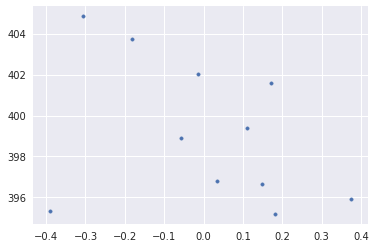

In [56]:
# mask=(taus_cont>0)&(taus_cont<80)

plt.scatter(np.maximum(one_amplitudes, two_amplitudes)[mask], abs_taus_cont[mask], marker='.')
plt.figure()
plt.scatter(((one_amplitudes-two_amplitudes)/(one_amplitudes+two_amplitudes))[mask], 
            abs_taus_cont[mask], 
            marker='.')

caption: 
single photon pulses leaking into 2 photon population caused the spike in 0-50ns bin increase in population 

it's effects decay as tau increases.

## Amplitude 1 vs Amplitude 2

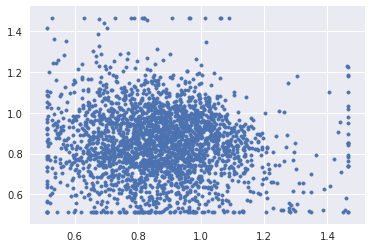

In [18]:
plt.scatter(one_amplitudes,two_amplitudes,marker='.')

## Histogram of Min, Max Ampltudes from Least Squares Fit

(array([  16.,   58.,  243.,  479.,  587.,  412.,   89.,   13.,    3.,   16.]),
 array([ 0.5126331 ,  0.60791876,  0.70320442,  0.79849008,  0.89377574,
         0.9890614 ,  1.08434706,  1.17963272,  1.27491838,  1.37020404,
         1.4654897 ]),
 <a list of 10 Patch objects>)

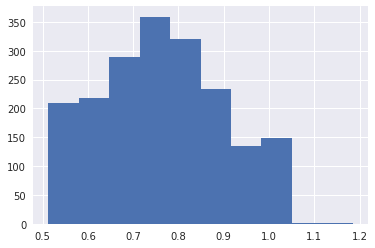

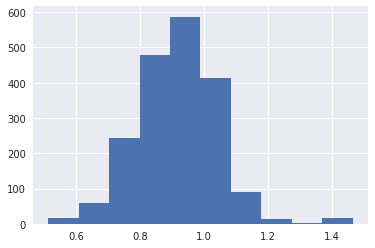

In [19]:
plt.hist(np.minimum(one_amplitudes,two_amplitudes)[~mcmc_flags])
plt.figure();plt.hist(np.maximum(one_amplitudes,two_amplitudes)[~mcmc_flags])

caption: amplitudes remain mostly at default values without change: justifies use of MCMC instead of least squares

## Maximum Amplitude is limited for cases when MCMC is activated

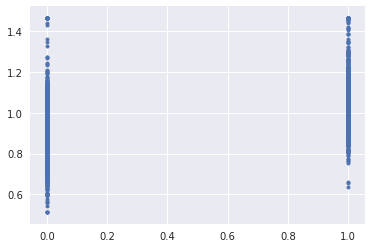

In [104]:
plt.scatter(mcmc_flags, np.maximum(one_amplitudes,two_amplitudes),marker='.')

(0, 80)

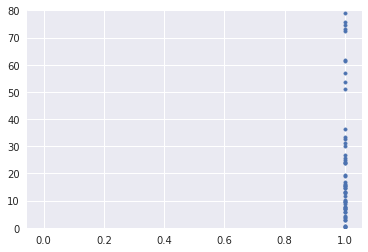

In [115]:
plt.scatter(mcmc_flags, abs_taus_cont, marker='.')
plt.ylim(0,80)

## Plots from MCMC

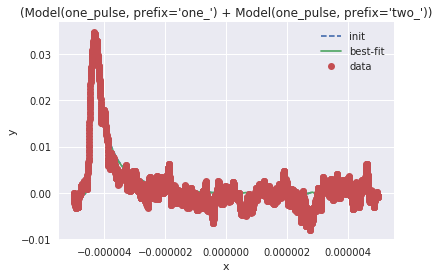

In [122]:
mask = np.minimum(one_amplitudes,two_amplitudes)>0.6
trace = '/home/jianwei_leejw/data/20161116_TES5_20MHz_bwl_diode_n012_height_optimised/continuous_diode/'+\
np.array(fnames)[mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)][0]+'.trc'
np.array(results_formatted_cont)[mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)][0].plot_fit()

caption: single photon pulses activates MCMC fitting since there is only one pulse region. Thus 0.5 amplitude pulses are overrepresented within MCMC fitted pulses.

In [148]:
np.sum([~mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)])

17

In [109]:
def testcw(fname, sampling, burn, thin, height_th, Plot=True):
    result, mcmc_flag, unequal_edges = fit_two_cw(*hpa.trace_extr(fname, 
                                                  t_initial, t_final), 
                            
                                  height_th=height_th, 
                                  sampling=sampling,
                                 burn=burn,
                                 thin=thin,
                                debug=True)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.figure()
        plt.plot(*hpa.trace_extr(fname), label='unwindowed', color='grey')
        result.plot_fit()
        plt.savefig(results_directory+'testmcmccw.pdf')
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
    return result, mcmc_flag, unequal_edges

(-4.7800599153131698e-06, -3.9000599402012695e-06, None)
 [-----------------100%-----------------] 15000 of 15000 complete in 5.8 secPlotting two_x_amplitude
Plotting one_x_offset
Plotting one_x_amplitude
Plotting two_x_offset
[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:   -4.5074e-06 +/- nan      (nan%) (init=-4.513963e-06)
    two_x_offset:   -4.5072e-06 +/- nan      (nan%) (init=-4.500213e-06)
    one_amplitude:   0.85888363 +/- 1.66e+04 (1935076.86%) (init= 0.824722)
    two_amplitude:   0.94526775 +/- 1.66e+04 (1758237.23%) (init= 0.9898061)
[[Correlations]] (unreported correlations are <  0.100)
    C(one_amplitude, two_amplitude)  = -1.000 

arrival time difference = -13.75ns


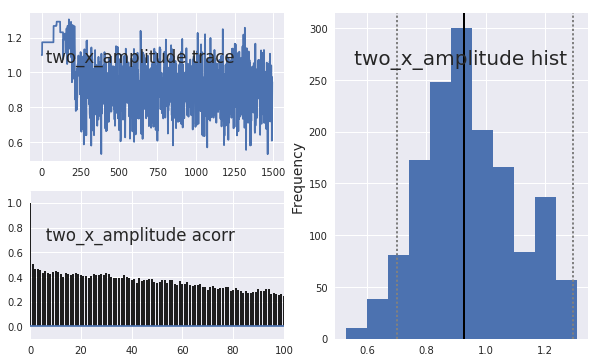

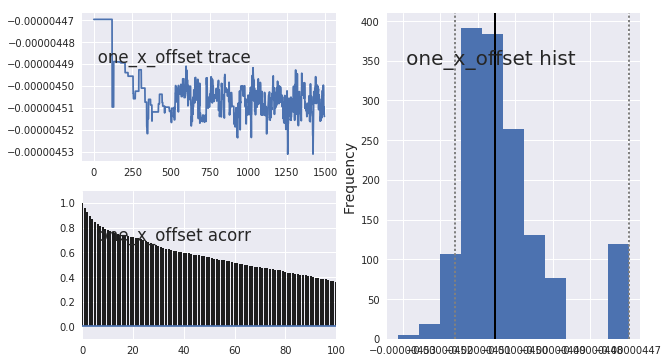

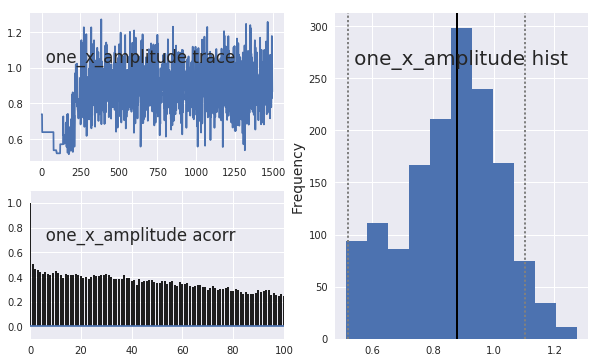

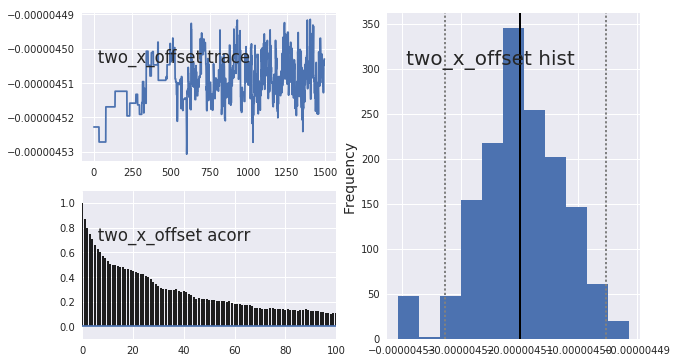

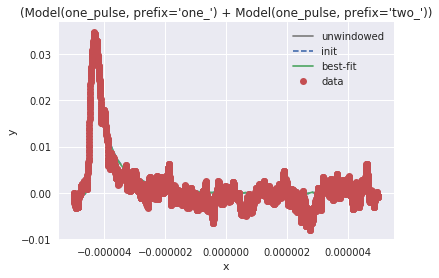

In [152]:
a, b, c = testcw(trace,sampling=1.5e4,burn=40,thin=10,
                height_th=height_th,Plot=True);

### Save a reduced version of the results

In [178]:
# Just extract the amplitudes and offsets from Bayesian or LMfit fits
keys = results_formatted_cont[0].init_values.keys()
dtype = [(key,'float') for key in keys]
results_cont_reduced =[tuple(np.array(r.init_values.values())) for r in results_formatted_cont]
results_cont_reduced = np.array(results_cont_reduced,dtype=dtype)
np.savetxt(results_directory+'results_cont_2nspp_reduced.dat',
           results_cont_reduced, header='\t'.join(results_cont_reduced.dtype.names))

### Load a reduced version of the results

In [ ]:
results = np.genfromtxt(results_directory+'results_cont_reduced.dat', names=True)
plt.figure()
plt.scatter(results['one_amplitude'],results['two_amplitude'])
plt.figure()
plt.hist(results['one_amplitude']-results['two_amplitude']/(results['one_amplitude']+results['two_amplitude']),100);

# Plotting Functions for troubleshooting

In [ ]:
plt.figure()
plt.plot(*hpa.trace_extr(filelist_cont[mask_2ph_cont][(abs_taus_cont>20)&(abs_taus_cont<50)][1]))
plt.xlim(0,2e-6)

In [ ]:
IntResult = np.array(results_cont)[(taus_cont>-60)&(taus_cont<-20)][3]
# IntResult = a #Interesting Result
time = hpa.trace_extr((filelist_cont[0]))[0]
time = time[time>=-2e-6]
signal = IntResult.data[time>=-2e-6]

plt.figure()
plt.xlim(0.2e-6,0.6e-6)
plt.plot(time, signal, label='data')

one_signal = one_pulse(time, IntResult.init_values['one_x_offset'], IntResult.init_values['one_amplitude'])
two_signal = one_pulse(time, IntResult.init_values['two_x_offset'], IntResult.init_values['two_amplitude'])

plt.plot(time,one_signal+two_signal,label='both pulses (mcmc)')
plt.plot(time,one_signal,label='first pulse (mcmc)')
plt.plot(time,two_signal,label='second pulse (mcmc)')
plt.legend()

plt.text(1.75e-6,0.03,IntResult.fit_report(),fontsize=5, va='top', ha='right')
plt.title('Bayesian fitted time difference = {:.2f}ns'\
    .format(np.abs(IntResult.init_values['one_x_offset']-IntResult.init_values['two_x_offset'])*1e9)
)

# Save plot, traces, report
# plt.savefig(results_directory + 'mcmc_fitted_components_cont.pdf')
# np.savetxt(results_directory+'mcmc_fitted_components_cont.dat',
#           zip(time,signal,one_signal,two_signal),
#           header="time\tsignal\tone_signal\ttwo_signal")
# with open("mcmc_fitted_components_cont.txt", "w") as text_file:
#     text_file.write("Purchase Amount: {0}".format(IntResult.fit_report()))

In [ ]:
# traces that fall between 0ns and _cont separation
plt.figure()
[plt.plot(r.data[::10], alpha=0.1) for r in np.array(results_cont)[(taus_cont>-60)&(taus_cont<-50)]];
plt.xlim(110,140)

In [ ]:
# traces that are correctly fitted for _cont separation
plt.figure()
[plt.plot(r.data[::10], alpha=0.1) for r in np.array(results_cont)[(taus_cont>-20)&(taus_cont<0)]];
plt.xlim(110,140)

In [ ]:
def testmcmc_bydata(time, signal, iters, height_th, Plot=True):
    result, result_mcmc = fit_two(time, signal, 
                                                  
                                  height_th=height_th, 
                                  sampling=iters)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.plot(time, signal, label='unwindowed')
        plt.plot(result_mcmc.time, result_mcmc.signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(result_mcmc.time, result_mcmc.mod_two_pulse.value,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.legend()
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
        pymc.Matplot.plot(result_mcmc)
    return result, result_mcmc

# a, b = testmcmc_bydata(time, signal,2e4,height_th,Plot=True)

# Load Pickle results

In [151]:
fileObject = open('lmfit_data_cont','r')
PickleObject=pickle.load(fileObject)

<IPython.core.display.Javascript object>


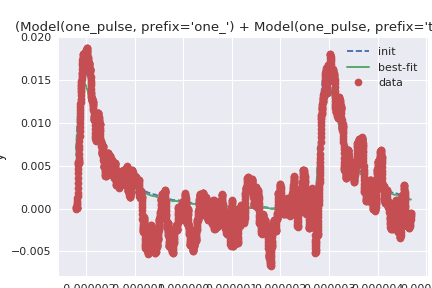

In [168]:
plt.figure()
PickleObject[315][0].plot_fit()

In [ ]:
results_formatted_cont